In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def fetch_ohlcv(exchange_name: str,
                symbol: str,
                since: int = None,
                limit: int = 1000) -> pd.DataFrame:
    exchange = getattr(ccxt, exchange_name)()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df[['open','high','low','close','volume']]

def get_pair_data(exchange_name: str,
                  symbol_a: str,
                  symbol_b: str,
                  since: int = None,
                  limit: int = 1000) -> pd.DataFrame:
    df_a = fetch_ohlcv(exchange_name, symbol_a, since, limit)
    df_b = fetch_ohlcv(exchange_name, symbol_b, since, limit)

    # align on datetime and take only the closing prices
    df = pd.concat([
        df_a['close'].rename(symbol_a),
        df_b['close'].rename(symbol_b)
    ], axis=1).dropna()

    return df

/Users/lukasschaller/Documents/Programmieren/2025/coint-pairs-trader/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
symbol_a = 'ETH/USDT'
symbol_b = 'BCH/USDT'

In [3]:
data = get_pair_data('binance', symbol_a, symbol_b, limit=1000)

In [4]:
rolling_window = 50
entry_threshold = 2.
exit_threshold = 0.25

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

y = data[symbol_a]
X = sm.add_constant(data[symbol_b])
rols = RollingOLS(y, X, window=rolling_window)
model = rols.fit()
data['alpha']    = model.params['const']
data['beta']     = model.params[symbol_b]
data['residual'] = data[symbol_a] - (data['alpha'] + data['beta'] * data[symbol_b])

data['mean_res'] = data['residual'].rolling(window=rolling_window).mean()
data['std_res']  = data['residual'].rolling(window=rolling_window).std()
data['z_score']  = (data['residual'] - data['mean_res']) / data['std_res']

data = data.dropna(subset=['alpha','beta','residual','z_score'])

# setup backtesting
data['position'] = 0 # +1 = long spread, -1 = short spread, 0 = neutral
data['a_pos'] = 0.0
data['b_pos'] = 0.0
data['pnl'] = 0.0

def size_positions(price_a, price_b, beta=1.0):
    size_a = 1.0
    size_b = price_a / price_b * size_a * beta
    return size_a, size_b

In [5]:
state    = 'neutral'
entry_pa = entry_pb = 0.0
stop_loss_pct = 1

for idx, row in data.iterrows():
    z    = row['z_score']
    pa   = row[symbol_a]
    pb   = row[symbol_b]
    hb   = row['beta']
    

    if state == 'neutral':
        if z <= -entry_threshold:
            # Long spread: buy A, sell B
            sa, sb = size_positions(pa, pb)
            entry_pa, entry_pb = pa, pb
            data.at[idx,'a_pos']    =  sa
            data.at[idx,'b_pos']    = -sb
            data.at[idx,'position'] =  1
            state = 'long'

        elif z >= entry_threshold:
            # Short spread: sell A, buy B
            sa, sb = size_positions(pa, pb)
            entry_pa, entry_pb = pa, pb
            data.at[idx,'a_pos']    = -sa
            data.at[idx,'b_pos']    =  sb
            data.at[idx,'position'] = -1
            state = 'short'
        # else remain flat (positions already zeroed)

    else:
        # carry forward the positions
        prev = data.loc[:idx].iloc[-2]
        data.at[idx,'a_pos']    = prev['a_pos']
        data.at[idx,'b_pos']    = prev['b_pos']
        data.at[idx,'position'] = 1 if state=='long' else -1

        sign =  1 if state=='long' else -1
        pnl_pct_A = sign * (pa - entry_pa) / entry_pa
        pnl_pct_B = sign * (entry_pb - pb)  / entry_pb

        if abs(z) < exit_threshold:
            exit_reason = 'z_exit'
        elif (pnl_pct_A < -stop_loss_pct) or (pnl_pct_B < -stop_loss_pct):
            exit_reason = 'stop_loss'
        else:
            exit_reason = None

        if exit_reason:
            pnl_A = (pa - entry_pa) * prev['a_pos']
            pnl_B = (pb - entry_pb) * prev['b_pos']
            data.at[idx,'pnl'] = pnl_A + pnl_B

            data.at[idx,'a_pos']    = 0.0
            data.at[idx,'b_pos']    = 0.0
            data.at[idx,'position'] = 0
            state = 'neutral'
            data.at[idx,'exit_reason'] = exit_reason

Total PnL: -4985.22
Annualized Sharpe: -0.93
Max Drawdown: -5110.80


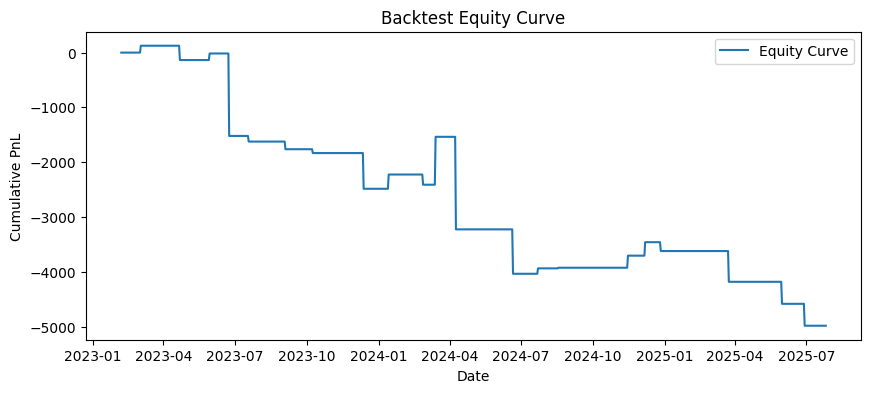

In [6]:
data['cum_pnl'] = data['pnl'].cumsum()
total_return = data['cum_pnl'].iat[-1]
sharpe = data['pnl'].mean() / data['pnl'].std() * np.sqrt(252)
max_dd = (data['cum_pnl'] - data['cum_pnl'].cummax()).min()

print(f"Total PnL: {total_return:.2f}")
print(f"Annualized Sharpe: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(data.index, data['cum_pnl'], label='Equity Curve')
plt.title('Backtest Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()


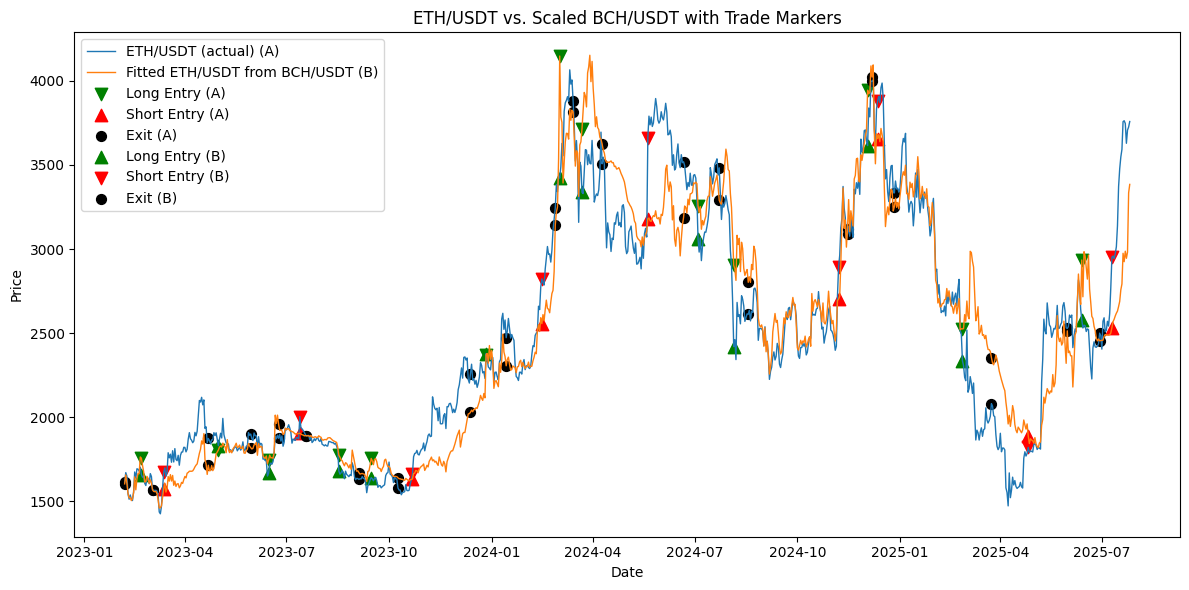

In [7]:
import matplotlib.pyplot as plt

data['fitted_a'] = data['alpha'] + data['beta'] * data[symbol_b]

long_entries  = data[(data['position'] ==  1) & (data['position'].shift(1) == 0)]
short_entries = data[(data['position'] == -1) & (data['position'].shift(1) == 0)]
exits         = data[(data['position'] ==  0) & (data['position'].shift(1) != 0)]

# 3) Plot actual vs. fitted with markers
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[symbol_a], label=f'{symbol_a} (actual) (A)', lw=1)
plt.plot(data.index, data['fitted_a'], label=f'Fitted {symbol_a} from {symbol_b} (B)', lw=1)

# Mark long/short entries and exits on actual prices
plt.scatter(long_entries.index,  long_entries['fitted_a'],  marker='v', s=80,  color='green', label='Long Entry (A)')
plt.scatter(short_entries.index, short_entries['fitted_a'], marker='^', s=80,  color='red',   label='Short Entry (A)')
plt.scatter(exits.index,         exits['fitted_a'],         marker='o', s=50,  color='black', label='Exit (A)')
plt.scatter(long_entries.index,  long_entries[symbol_a],  marker='^', s=80,  color='green', label='Long Entry (B)')
plt.scatter(short_entries.index, short_entries[symbol_a], marker='v', s=80,  color='red',   label='Short Entry (B)')
plt.scatter(exits.index,         exits[symbol_a],         marker='o', s=50,  color='black', label='Exit (B)')

plt.title(f'{symbol_a} vs. Scaled {symbol_b} with Trade Markers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
ret_a = data[symbol_a].pct_change().dropna()
ret_b = data[symbol_b].pct_change().dropna()

returns = pd.concat([ret_a, ret_b], axis=1, join='inner')
returns['ew_portfolio'] = 0.5 * returns[symbol_a] + 0.5 * returns[symbol_b]

daily_mean = returns['ew_portfolio'].mean()
daily_std  = returns['ew_portfolio'].std()
sharpe     = daily_mean / daily_std * np.sqrt(252)

print(f"Equal-Weighted {symbol_a}, {symbol_b} Portfolio Annualized Sharpe: {sharpe:.2f}")

Equal-Weighted ETH/USDT, BCH/USDT Portfolio Annualized Sharpe: 0.92


We observe that the annualized Sharpe ratio of our strategy is worse (and for many of the currency pairs that we chose in [02_currency_choice.ipynb](02_currency_choice.ipynb), it was negative) than the equal-weighted portfolio of the two assets. A careful analysis of the trades suggests that the trend of these two assets to move together is not strong enough to balance general market movements. Hence all profits are eroded by the volatility of the market. Therefore, we conclude that for this strategy to succeed we need to consider pairs of assets that are extremely cointegrated. For further details see [05_etfs.ipynb](05_etfs.ipynb) where we apply the same strategy to ETFs.